In [1]:
import xarray as xr
import numpy as np
import multiprocessing as mp
from matplotlib import pyplot as plt
from datetime import datetime
from scipy.ndimage.filters import gaussian_filter as gf

In [2]:
def create_noise(xnum, ynum, dy, cutoff, taper_length, max_val):
    n = taper_length
    s = ynum / (ynum * dy / cutoff)
    whitenoise = np.random.random(size=(ynum, xnum))
    fnoise = gf(whitenoise, sigma=s)
    fnoise -= np.mean(fnoise)
    k = np.arange(0, n + 1)
    taper1side = np.sin(np.pi * k / n) * n / (np.pi * k)
    taper1side[-1] = 0
    taperx = np.hstack((np.hstack((taper1side[:0:-1], np.ones(xnum - (2 * n)))), taper1side[1:]))
    tapery = np.hstack((np.hstack((taper1side[:0:-1], np.ones(ynum - (2 * n)))), taper1side[1:]))
    taper = tapery[:, None] * taperx[None, :]
    fnoise *= taper
    return fnoise / np.max(np.abs(fnoise)) * max_val

In [3]:
#data = xr.open_mfdataset("/home/jan/Data/MITgcm_test_data/helm_deco/"
#                         + "test_data_velocities_tz.original.nc").isel(time=slice(0, 2), Z=slice(0, 10))
#U = data.UVEL.values
#V = np.zeros((np.shape(U)[0], np.shape(U)[1], np.shape(U)[2] + 1, np.shape(U)[3]))
#V[:, :, 0:-1, :] = data.VVEL.values
#
#dUx = np.zeros(U.shape)
#dUx[:, :, :, 0:-1] = (U[:, :, :, 1::] - U[:, :, :, 0:-1]) / 10000.
#dUx[:, :, :, -1] = (U[:, :, :, 0] - U[:, :, :, -1]) / 10000.
#dVy = np.zeros(U.shape)
#dVy[:, :, 1::, :] = (V[:, :, 2::, :] - V[:, :, 1:-1, :]) / 10000.
#divergence = dUx + dVy
#divergence[:, :, 0:2, :] = 0

## Helmholtz decomposition

The Helmholtz decomposition can be used to decompose a velocity field $\vec{v}$ into its divergent and rotational parts. Here we are only interested in the divergent part $\vec{v}_{div}$ which can be represented by

$ \vec{v}_{div} = \nabla \phi $  

where $\phi$ is a potential defined by  

$ \nabla^{2} \phi = \nabla \cdot \vec{v} $  

$ \frac{\partial^{2} \phi}{\partial x^{2}} + \frac{\partial^{2} \phi}{\partial y^{2}} = \nabla \cdot \vec{v} $  

$ \frac{\partial^{2} \phi}{\partial x^{2}} + \frac{\partial^{2} \phi}{\partial y^{2}} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $  

$ \frac{\partial^{2} \phi}{\partial x^{2}} + \frac{\partial^{2} \phi}{\partial y^{2}} = D $  

$D$ can be easily computed from our initial field $\vec{v}$  

Discretize the equation  

$ \frac{\phi_{i+1,j} - 2 \phi_{i,j} + \phi_{i-1,j}}{(\Delta x)^{2}} + \frac{\phi_{i,j+1} - 2 \phi_{i,j} + \phi_{i,j-1}}{(\Delta y)^{2}} = D_{i,j} $  

with $\Delta x = \Delta y = \Delta$  

$ \phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - 4 \phi_{i,j} = D_{i,j} \Delta^{2} $  

$ \phi_{i,j} = \frac{1}{4} (\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - D_{i,j} \Delta^{2}) $

In [4]:
nx = 120
ny = 200
nz = 10
nt = 3
delta = 1e3

In [15]:
divergence = np.ones((nt, nz, ny, nx))
divergence *= np.arange(0, ny)[None, None, :, None]
divergence *= np.sin(np.linspace(0, 12, nx))[None, None, None, :]
divergence[:, :, :, 0] = 0
divergence[:, :, :, -1] = 0
divergence[:, :, 0, :] = 0
divergence[:, :, -1, :] = 0
divergence /= 1e5
divergence *= create_noise(nx, ny, delta, 4400, 3, np.max(divergence) * 2)

<ipython-input-2-b127d127f632>:8: RuntimeWarning: invalid value encountered in true_divide
  taper1side = np.sin(np.pi * k / n) * n / (np.pi * k)


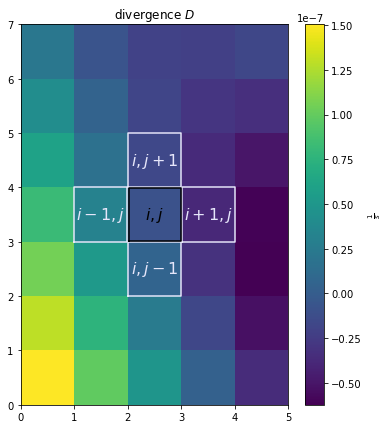

In [16]:
div = divergence[0, 0, 22:29, 19:24]
delta2 = delta ** 2

plt.figure(figsize=(6, 7))
plt.pcolormesh(div)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"divergence $D$")
plt.plot([2, 3, 3, 2, 2], [2, 2, 2.99, 2.99, 2], color="lavender")
plt.plot([2, 3, 3, 2, 2], [4.01, 4.01, 5, 5, 4.01], color="lavender")
plt.plot([1, 1.99, 1.99, 1, 1], [3, 3, 4, 4, 3], color="lavender")
plt.plot([3.01, 4, 4, 3.01, 3.01], [3, 3, 4, 4, 3], color="lavender")
plt.plot([2.02, 2.99, 2.99, 2.02, 2.02], [3.02, 3.02, 3.98, 3.98, 3.02], color="k")
plt.text(2.5, 3.5, r"$i, j$", fontsize=16, ha="center", va="center", color="k")
plt.text(3.5, 3.5, r"$i+1, j$", fontsize=16, ha="center", va="center", color="lavender")
plt.text(1.5, 3.5, r"$i-1, j$", fontsize=16, ha="center", va="center", color="lavender")
plt.text(2.5, 4.5, r"$i, j+1$", fontsize=16, ha="center", va="center", color="lavender")
plt.text(2.5, 2.5, r"$i, j-1$", fontsize=16, ha="center", va="center", color="lavender");

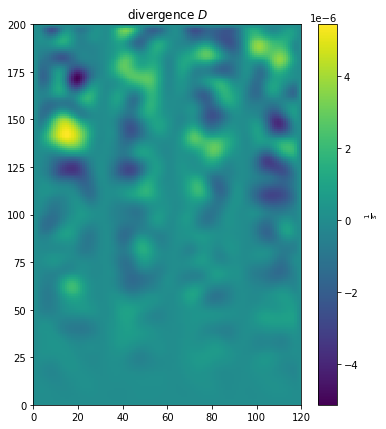

In [17]:
D = divergence[0, 0, :, :]

plt.figure(figsize=(6, 7))
plt.pcolormesh(D)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"divergence $D$");

### The pythonic way

Jacobi method

In [18]:
# initial guess
phi = np.zeros(np.shape(D))

phi[1:-1, 1:-1] = 0.25 * (phi[0:-2, 1:-1] + phi[2::, 1:-1] + phi[1:-1, 0:-2] + phi[1:-1, 2::] - D[1:-1, 1:-1] * delta2)

# set the boundary conditions
phi[0, :] = phi[1, :]
phi[-1, :] = phi[-2, :]
phi[:, 0] = phi[:, 1]
phi[:, -1] = phi[:, -2]

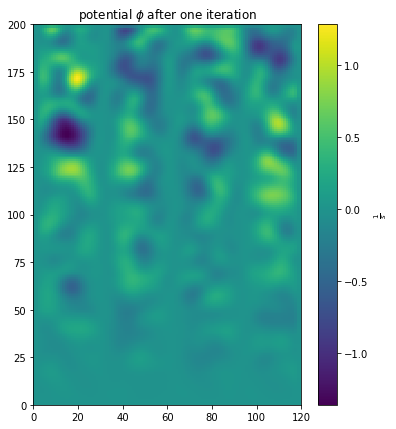

In [19]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after one iteration");

In [20]:
phi[1:-1, 1:-1] = 0.25 * (phi[0:-2, 1:-1] + phi[2::, 1:-1] + phi[1:-1, 0:-2] + phi[1:-1, 2::] - D[1:-1, 1:-1] * delta2)

# set the boundary conditions
phi[0, :] = phi[1, :]
phi[-1, :] = phi[-2, :]
phi[:, 0] = phi[:, 1]
phi[:, -1] = phi[:, -2]

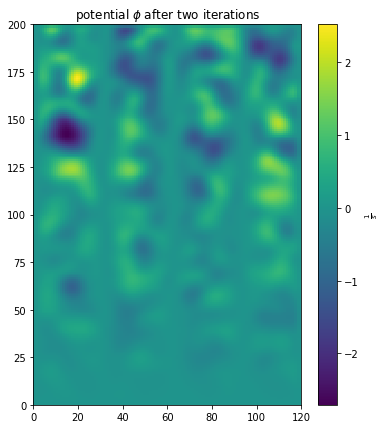

In [21]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after two iterations");

In [22]:
phi = np.zeros(np.shape(D))
target_residual = 1e-4
max_iter = 1e5

earlier = datetime.now()
it = 1
res = 1
while( res  >= target_residual ):
    phi_b = phi.copy()
    phi[1:-1, 1:-1] = 0.25 * (phi[0:-2, 1:-1] + phi[2::, 1:-1] + phi[1:-1, 0:-2] + phi[1:-1, 2::] - (D[1:-1, 1:-1] * delta2))
    # set the boundary conditions
    phi[0, :] = phi[1, :]
    phi[-1, :] = phi[-2, :]
    phi[:, 0] = phi[:, 1]
    phi[:, -1] = phi[:, -2]
    if np.sum(phi_b == 0):
        res = 1
    else:
        res = np.sum(abs(phi_b - phi)) / np.sum(phi)
    if it < max_iter:
        it += 1
    else:
        break

print("Achieved target residual in", it, "iterations.")
print("The computation took", (datetime.now() - earlier).total_seconds(), "seconds.")

Achieved target residual in 13784 iterations.
The computation took 2.431315 seconds.


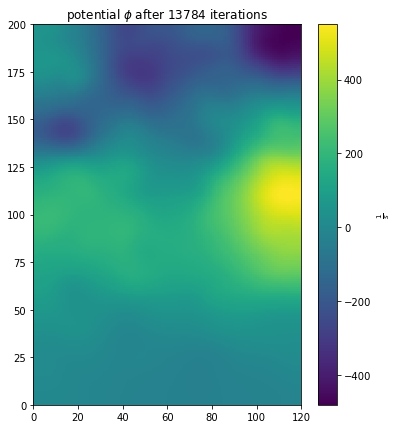

In [23]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after " + str(it) + " iterations");

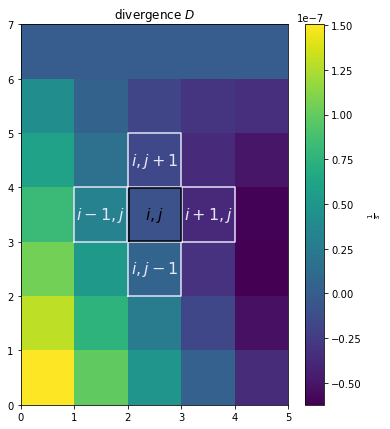

In [24]:
div = divergence[0, 0, 22:29, 19:24]
div[-1, :] = 0

plt.figure(figsize=(6, 7))
plt.pcolormesh(div)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"divergence $D$")
plt.plot([2, 3, 3, 2, 2], [2, 2, 2.99, 2.99, 2], color="lavender")
plt.plot([2, 3, 3, 2, 2], [4.01, 4.01, 5, 5, 4.01], color="lavender")
plt.plot([1, 1.99, 1.99, 1, 1], [3, 3, 4, 4, 3], color="lavender")
plt.plot([3.01, 4, 4, 3.01, 3.01], [3, 3, 4, 4, 3], color="lavender")
plt.plot([2.02, 2.99, 2.99, 2.02, 2.02], [3.02, 3.02, 3.98, 3.98, 3.02], color="k")
plt.text(2.5, 3.5, r"$i, j$", fontsize=16, ha="center", va="center", color="k")
plt.text(3.5, 3.5, r"$i+1, j$", fontsize=16, ha="center", va="center", color="lavender")
plt.text(1.5, 3.5, r"$i-1, j$", fontsize=16, ha="center", va="center", color="lavender")
plt.text(2.5, 4.5, r"$i, j+1$", fontsize=16, ha="center", va="center", color="lavender")
plt.text(2.5, 2.5, r"$i, j-1$", fontsize=16, ha="center", va="center", color="lavender");

### We need a loop

Gauss-Seidel method

In [25]:
phi = np.zeros(np.shape(D))
target_residual = 1e-4
max_iter = 1e5

earlier = datetime.now()
it = 1
res = 1
while( res  >= target_residual ):
    phi_b = phi.copy()
    for j in np.arange(1, ny-1):
        for i in np.arange(1, nx-1):
            phi[j, i] = 0.25 * (phi[j, i+1] + phi[j, i-1] + phi[j+1, i] + phi[j-1, i] - (D[j, i] * delta2))
    # set the boundary conditions
    phi[0, :] = phi[1, :]
    phi[-1, :] = phi[-2, :]
    phi[:, 0] = phi[:, 1]
    phi[:, -1] = phi[:, -2]
    if np.sum(phi_b == 0):
        res = 1
    else:
        res = np.sum(abs(phi_b - phi)) / np.sum(phi)
    if it < max_iter:
        it += 1
    else:
        break

print("Achieved target residual in", it, "iterations.")
print("The computation took", (datetime.now() - earlier).total_seconds(), "seconds.")

Achieved target residual in 10277 iterations.
The computation took 559.23742 seconds.


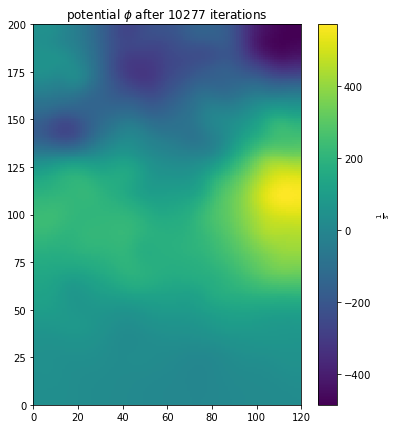

In [26]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after " + str(it) + " iterations");

Loops take very long in languages like python. They are a lot faster in compiled languages like FORTRAN. So we write the loop in FORTRAN.

In [27]:
with open("GS_loop.f95", "w") as file:
    file.write("subroutine solve(D, phi, delta, nx, ny)\n" +
               "! =====================================================\n" +
               "! Solve poisson equation with Gauss-Seidel\n" +
               "! =====================================================\n" +
               "    integer, intent(in)                            :: nx, ny\n" +
               "    real, intent(in)                               :: delta\n" +
               "    real(kind=8), intent(in), dimension(ny, nx)    :: D(ny, nx)\n" +
               "    real(kind=8), intent(inout), dimension(ny, nx) :: phi(ny, nx)\n" +
               "    integer                                        :: i, j\n" +
               "    real(kind=8)                                   :: tmp\n" +
               " \n" +
               "    do i = 2, nx-1\n" +
               "        do j = 2, ny-1\n" +
               "            phi(j, i) = 0.25 * (phi(j, i+1) + phi(j, i-1) &\n" +
               "                            & + phi(j+1, i) + phi(j-1, i) &\n" +
               "                            & - ((delta * delta) * D(j, i)))\n" +
               "        end do\n" +
               "    end do\n" +
               " \n" +
               "end subroutine solve"
               )

In [28]:
!python3 -m numpy.f2py -c GS_loop.f95 -m GS_loop

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "GS_loop" sources
f2py options: []
f2py:> /tmp/tmpgjgbckos/src.linux-x86_64-3.8/GS_loopmodule.c
creating /tmp/tmpgjgbckos/src.linux-x86_64-3.8
Reading fortran codes...
	Reading file 'GS_loop.f95' (format:free)
Post-processing...
	Block: GS_loop
			Block: solve
Post-processing (stage 2)...
Building modules...
	Building module "GS_loop"...
		Constructing wrapper function "solve"...
		  solve(d,phi,delta,[nx,ny])
	Wrote C/API module "GS_loop" to file "/tmp/tmpgjgbckos/src.linux-x86_64-3.8/GS_loopmodule.c"
  adding '/tmp/tmpgjgbckos/src.linux-x86_64-3.8/fortranobject.c' to sources.
  adding '/tmp/tmpgjgbckos/src.linux-x86_64-3.8' to include_dirs.
copying /home/jan/miniconda3/envs/py3_eddy_new/lib/python3.8/site-packages/numpy/f2

In [29]:
import GS_loop

In [30]:
D = np.array(D, order="F")
phi = np.zeros(np.shape(D), order="F")
target_residual = 1e-4
max_iter = 1e5

earlier = datetime.now()
it = 1
res = 1
while( res  >= target_residual ):
    phi_b = phi.copy()
    GS_loop.solve(D, phi, delta, nx, ny)
    # set the boundary conditions
    phi[0, :] = phi[1, :]
    phi[-1, :] = phi[-2, :]
    phi[:, 0] = phi[:, 1]
    phi[:, -1] = phi[:, -2]
    if np.sum(phi_b == 0):
        res = 1
    else:
        res = np.sum(abs(phi_b - phi)) / np.sum(phi)
    if it < max_iter:
        it += 1
    else:
        break

print("Achieved target residual in", it, "iterations.")
print("The computation took", (datetime.now() - earlier).total_seconds(), "seconds.")

Achieved target residual in 10277 iterations.
The computation took 1.573555 seconds.


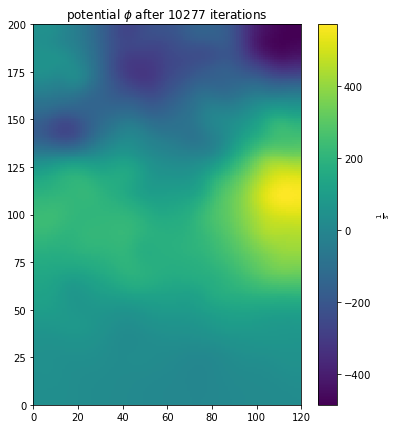

In [31]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after " + str(it) + " iterations");

## SOR

In [32]:
with open("SOR_loop.f95", "w") as file:
    file.write("subroutine solve(D, phi, om, delta, nx, ny)\n" +
               "! =====================================================\n" +
               "! Solve poisson equation with SOR\n" +
               "! =====================================================\n" +
               "    integer, intent(in)                            :: nx, ny\n" +
               "    real, intent(in)                               :: delta, om\n" +
               "    real(kind=8), intent(in), dimension(ny, nx)    :: D(ny, nx)\n" +
               "    real(kind=8), intent(inout), dimension(ny, nx) :: phi(ny, nx)\n" +
               "    integer                                        :: i, j\n" +
               "    real(kind=8)                                   :: tmp\n" +
               " \n" +
               "    do i = 2, nx-1\n" +
               "        do j = 2, ny-1\n" +
               "            tmp = (phi(j, i+1) + phi(j, i-1) &\n" +
               "               & + phi(j+1, i) + phi(j-1, i) &\n" +
               "               & - ((delta * delta) * D(j, i)))\n" +
               "            phi(j, i) = (((1 - om) * phi(j, i)) &\n" +
               "                            & + om * (tmp / 4))\n" +
               "        end do\n" +
               "    end do\n" +
               " \n" +
               "end subroutine solve"
               )

In [33]:
!python3 -m numpy.f2py -c SOR_loop.f95 -m SOR_loop

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "SOR_loop" sources
f2py options: []
f2py:> /tmp/tmpvezx3r0u/src.linux-x86_64-3.8/SOR_loopmodule.c
creating /tmp/tmpvezx3r0u/src.linux-x86_64-3.8
Reading fortran codes...
	Reading file 'SOR_loop.f95' (format:free)
Post-processing...
	Block: SOR_loop
			Block: solve
Post-processing (stage 2)...
Building modules...
	Building module "SOR_loop"...
		Constructing wrapper function "solve"...
		  solve(d,phi,om,delta,[nx,ny])
	Wrote C/API module "SOR_loop" to file "/tmp/tmpvezx3r0u/src.linux-x86_64-3.8/SOR_loopmodule.c"
  adding '/tmp/tmpvezx3r0u/src.linux-x86_64-3.8/fortranobject.c' to sources.
  adding '/tmp/tmpvezx3r0u/src.linux-x86_64-3.8' to include_dirs.
copying /home/jan/miniconda3/envs/py3_eddy_new/lib/python3.8/site-package

In [34]:
import SOR_loop

In [46]:
D = np.array(D, order="F")
phi = np.zeros(np.shape(D), order="F")
target_residual = 1e-4
max_iter = 1e5

earlier = datetime.now()
it = 1
res = 1
omega = 1.89
while( res  >= target_residual ):
    phi_b = phi.copy()
    SOR_loop.solve(D, phi, omega, delta, nx, ny)
    # set the boundary conditions
    phi[0, :] = phi[1, :]
    phi[-1, :] = phi[-2, :]
    phi[:, 0] = phi[:, 1]
    phi[:, -1] = phi[:, -2]
    if np.sum(phi_b == 0):
        res = 1
    else:
        res = np.sum(abs(phi_b - phi)) / np.sum(phi)
    if it < max_iter:
        it += 1
    else:
        break

print("Achieved target residual in", it, "iterations.")
print("The computation took", (datetime.now() - earlier).total_seconds(), "seconds.")

Achieved target residual in 9940 iterations.
The computation took 1.939645 seconds.


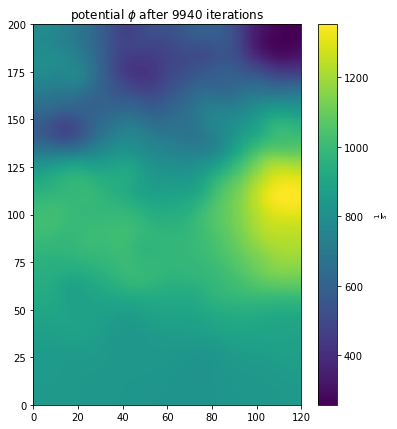

In [47]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi)
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after " + str(it) + " iterations");

In [ ]:
def apply_SOR_loop(t):
    residual = 1e-4
    npData = np.array(divergence[t, k, :, :], order='F')       
    PHI = np.zeros(np.shape(npData), order="F")
    om = 1.6
    it = 1
    res = 1
    while( res  >= residual ):
        PHI_b = PHI.copy()
        SOR_loop.solve(npData, PHI, delta, nx, ny)
        # set the boundary conditions
        PHI[0, :] = PHI[1, :]
        PHI[-1, :] = PHI[-2, :]
        PHI[:, 0] = PHI[:, 1]
        PHI[:, -1] = PHI[:, -2]
        if PHI_b[1:-1,:].sum() == 0:
            res = 1
        else:
            res = abs((PHI_b[1:-1,:].sum() - PHI[1:-1,:].sum()) / PHI_b[1:-1,:].sum())
        it += 1
    return PHI 

In [ ]:
phi = np.zeros(np.shape(divergence), order="F")
for k in np.arange(0, np.shape(phi)[1]):
    print("working on depth level", k)
    if __name__ == "__main__":
        with mp.Pool(mp.cpu_count() - 2) as p:
            phi[:, k, :, :] = p.map(apply_SOR_loop, np.arange(0, np.shape(divergence)[0]))
        p.close()
        p.join()

In [ ]:
plt.figure(figsize=(6, 7))
plt.pcolormesh(phi[5, 10, :, :])
plt.colorbar(label=r"$\frac{1}{s}$")
plt.title(r"potential $\phi$ after " + str(it) + " iterations");